In [3]:
import os
import pulp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [4]:
def get_mbs_data() -> pd.DataFrame: 
    
    parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
    data_path = os.path.join(parent_path, "data")
    mbs_path = os.path.join(data_path, "MBS.parquet")

    renamer = {
        "LUMSMD": "MBS_mod_dur",
        "LUMSOAS": "MBS_oas",
        "LUMSTRUU": "MBS_index"}

    df_mbs = (pd.read_parquet(
        path = mbs_path, engine = "pyarrow").
        rename(columns = renamer).
        reset_index().
        assign(date = lambda x: pd.to_datetime(x.date).dt.date).
        set_index("date"))
    
    return df_mbs

df_mbs = get_mbs_data()

In [5]:
def get_tsy_data() -> pd.DataFrame: 
    
    parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
    data_path = os.path.join(parent_path, "data")
    tsy_path = os.path.join(data_path, "tsy.parquet")

    df_tsy = (pd.read_parquet(
        path = tsy_path, engine = "pyarrow").
        rename(columns = {
            "CONVENTIONAL_CTD_FORWARD_FRSK": "ctd_duration",
            "FUT_EQV_CNVX_NOTL": "ctd_convexity"}).
        assign(date = lambda x: pd.to_datetime(x.date).dt.date).
        set_index("date"))
    
    return df_tsy

df_tsy = get_tsy_data()

In [8]:
df = (df_tsy.merge(
    right = df_mbs, how = "inner", on = ["date"]).
    assign(tmp_val = lambda x: (x.ctd_duration - x.MBS_mod_dur) ** 2)
    [["security", "tmp_val"]].
    reset_index().
    pivot(index = "date", columns = "security", values = "tmp_val"))

array([[<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
        <AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
        <AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
        <AxesSubplot:xlabel='date'>]], dtype=object)

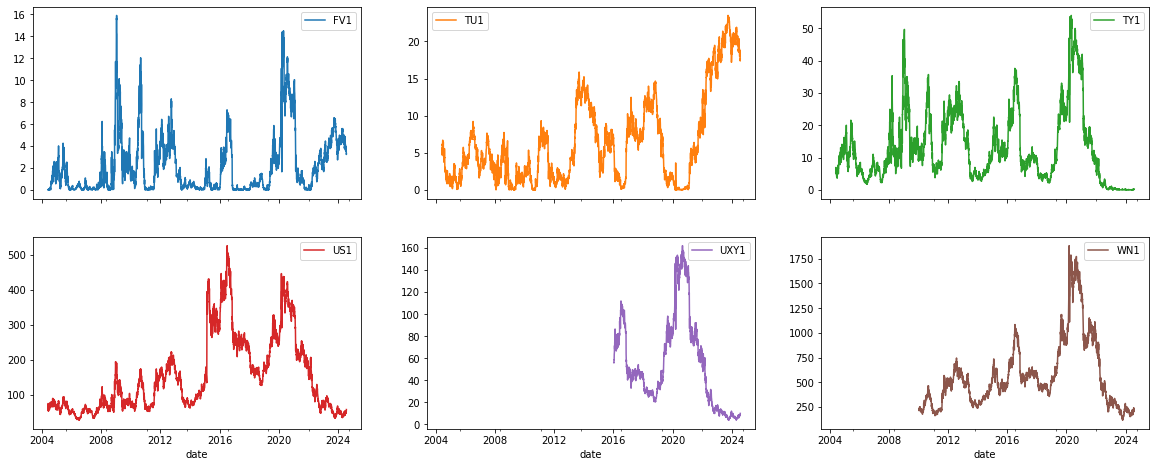

In [11]:
df.plot(subplots = True, layout = (3,3), figsize = (20,12))

In [37]:
def _get_logit(df: pd.DataFrame) -> pd.DataFrame: return(df.assign(
    log_value = lambda x: np.log(x.value)))

df_tmp = (df.reset_index().melt(
    id_vars = "date").
    dropna().
    groupby("security").
    apply(_get_logit).
    reset_index(drop = True))

C:\Users\Diego\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


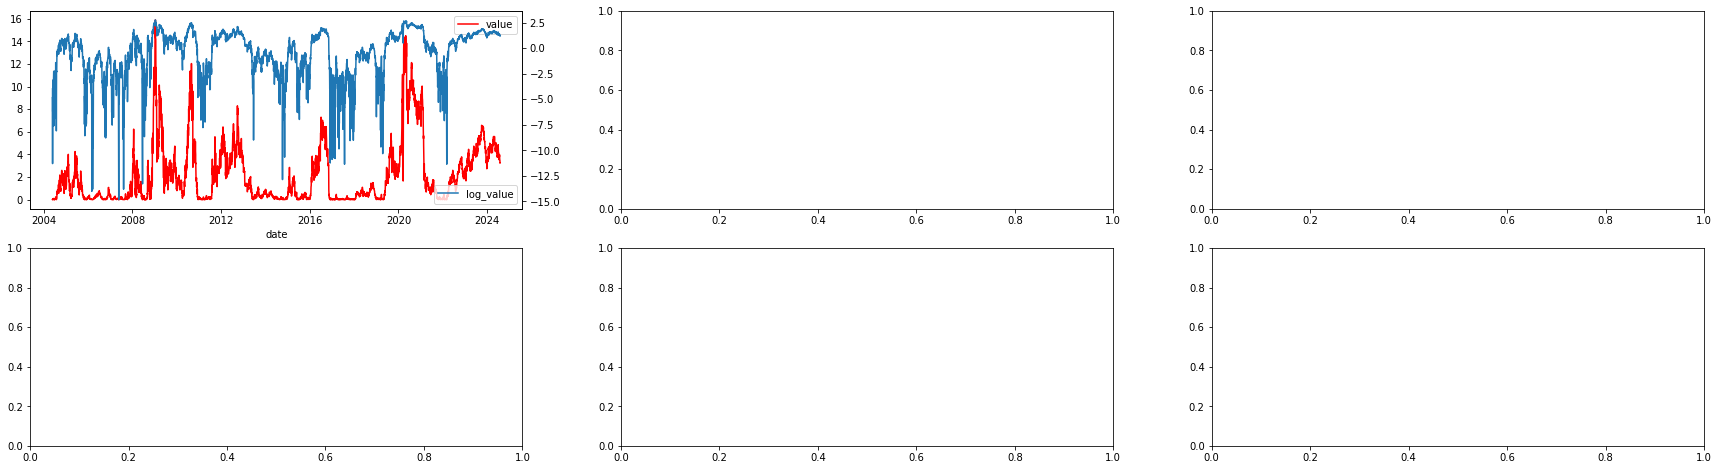

In [38]:
securities = df_tmp.security.drop_duplicates().to_list()
fig, axes = plt.subplots(ncols = len(securities) // 2, nrows = len(securities) // 3, figsize = (30,8))
for security, ax in zip(securities, axes.flatten()):
    
    df_plot = (df_tmp.query(
        "security == @security").
        drop(columns = ["security"]).
        set_index("date"))
    
    ax_copy = ax.twinx()
    (df_plot[
        ["value"]].
        plot(
            ax = ax,
            color = "red"))
    
    (df_plot[
        ["log_value"]].
        plot(
            ax = ax_copy))
    
    break